In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math as m
import matplotlib.figure as fig
import scipy.linalg
import scipy.optimize
import scipy.integrate
from scipy.stats import unitary_group
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
np.set_printoptions(linewidth=150)

####plot parameters
plt.rc('text', usetex=True)
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio (why ?)
fig_width = fig_width_pt*inches_per_pt  # width in inches (why ?)

fig_size =  [fig_width,0.75*fig_width]

params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 9,
          'legend.fontsize': 9,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': fig_size}

plt.rcParams.update(params)
plt.rc('lines', linewidth=1.2)
plt.rc('axes', linewidth=1.2)
#### end of plot parameters

omega=1
betaC,betaH,nuC,nuH=2,1,0.004,0.004 #arbitrary parameters
#express everything in the 00 01 10 11 basis
#U=np.matrix([[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,1]]) #unitary operation
U=np.matrix([[0,0,0,1],[0,1,0,0],[0,0,-1,0],[1,0,0,0]])
P=np.matrix([[1,0,0,0],[0,1/m.sqrt(2),1/m.sqrt(2),0],[0,-1/m.sqrt(2),1/m.sqrt(2),0],[0,0,0,1]]) #to go to energy basis
#U=np.asmatrix(unitary_group.rvs(4)) #random

def rates(G):
    a=nuC*(omega-G)/(m.exp(betaC*(omega-G))-1) #GAMMA c omega-G
    e=nuH*(omega-G)/(m.exp(betaH*(omega-G))-1) #GAMMA h omega-G
    c=nuC*(omega+G)/(m.exp(betaC*(omega+G))-1) #GAMMA c omega+G
    g=nuH*(omega+G)/(m.exp(betaH*(omega+G))-1) #GAMMA h omega+G
    b=a*m.exp(betaC*(omega-G)) #GAMMA hat c omega-G
    d=c*m.exp(betaC*(omega+G)) #GAMMA hat c omega+G
    f=e*m.exp(betaH*(omega-G)) #GAMMA hat h omega-G
    h=g*m.exp(betaH*(omega+G)) #GAMMA hat h omega+G
    
    return a,b,c,d,e,f,g,h

def steadystate(rates): # in 00 01 10 11 basis
    a,b,c,d,e,f,g,h = rates
    rho0=(b+f)*(d+h)
    rhoOplusG=(b+f)*(c+g)
    rhoOminusG=(a+e)*(d+h)
    rho2O=(a+e)*(c+g)
    r=np.diag([rho0,rhoOminusG,rhoOplusG,rho2O])
    r=r/np.trace(r)
    return P@r@P.getH()
    
def PPT(rho):#Peres-Horodecki criterion (must be negative to get entanglement)
    return rho[0,0]*rho[3,3]-rho[1,2]**2

def concurrence(rho):
    sigma=np.array([(0,0,0,-1),(0,0,1,0),(0,1,0,0),(-1,0,0,0)])
    rhotilde=sigma@np.conj(rho)@sigma
    R=scipy.linalg.sqrtm(scipy.linalg.sqrtm(rho)@rhotilde@scipy.linalg.sqrtm(rho))
    s=sorted(np.linalg.eigvals(R))
    return max(0,s[3]-s[0]-s[1]-s[2])

def logneg(rho):
    rhoTa=np.array([(rho[0,0],rho[1,0],rho[0,2],rho[1,2]),(rho[0,1],rho[1,1],rho[0,3],rho[1,3]),
                    (rho[2,0],rho[3,0],rho[2,2],rho[3,2]),(rho[2,1],rho[3,1],rho[2,3],rho[3,3])])
    return np.log2(np.trace(scipy.linalg.sqrtm(rhoTa@np.conj(rhoTa))))

def work_squarred(rho,U,H): # in the energy basis
    W2=0
    rhoe=P.getH()@rho@P # transform all the matrices in the energy basis
    He=P.getH()@H@P
    Ue=P.getH()@U@P
    for i in range(4):
        for j in range(4):
            W2=W2+((He[j,j]-He[i,i])**2)*rhoe[i,i]*Ue[i,j]*Ue[j,i]
    return W2

def mutualinfo(rho):
    rhoA=np.array([[rho[0,0]+rho[1,1],rho[0,2]+rho[1,3]],[rho[2,0]+rho[3,1],rho[2,2]+rho[3,3]]])
    rhoB=np.array([[rho[0,0]+rho[2,2],rho[0,1]+rho[2,3]],[rho[1,0]+rho[3,2],rho[1,1]+rho[3,3]]])
    return -np.trace(scipy.linalg.logm(rhoA)@rhoA)-np.trace(scipy.linalg.logm(rhoB)@rhoB)+np.trace(scipy.linalg.logm(rho)@rho)

In [3]:
def LO(L,rho):
    return L@rho@L.getH()-0.5*(L.getH()@L@rho+rho@L.getH()@L)

def lindblad(r,Ho,rates): #arguments in qubit basis
    rho=P.getH()@r@P #go to energy basis
    H=P.getH()@Ho@P
    a,b,c,d,e,f,g,h = rates
    Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
    Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
    Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    rep= -1j*(H@rho-rho@H)+a*LO(Lcminus.getH(),rho)+b*LO(Lcminus,rho)+c*LO(Lcplus.getH(),rho)+d*LO(Lcplus,rho)+e*LO(Lhminus.getH(),rho)+f*LO(Lhminus,rho)+g*LO(Lhplus.getH(),rho)+h*LO(Lhplus,rho)
    return P@rep@P.getH() #result in the qubit basis

def Jhot(r,Ho,rates):
    rho=P.getH()@r@P #go to energy basis
    H=P.getH()@Ho@P
    a,b,c,d,e,f,g,h = rates
    Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
    Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
    Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    return np.trace(H@(e*LO(Lhminus.getH(),rho)+f*LO(Lhminus,rho)+g*LO(Lhplus.getH(),rho)+h*LO(Lhplus,rho)))

def Jcold(r,Ho,rates):
    rho=P.getH()@r@P #go to energy basis
    H=P.getH()@Ho@P
    a,b,c,d,e,f,g,h = rates
    Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
    Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
    Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    return np.trace(H@(a*LO(Lcminus.getH(),rho)+b*LO(Lcminus,rho)+c*LO(Lcplus.getH(),rho)+d*LO(Lcplus,rho))) 

In [4]:
# Entropy excess from heat current
# Numerical resolution of lindblad equation
time,Nstep=1000,200 #adjust those parameters for the integration interval (time) and number of steps
 
def excessHeat(G,rho,H): # compute the integral of the difference between steady state and dynamical state during relaxation
    y0=U@rho@U.getH()
    y0=np.array(y0).reshape(16) #set initial state
    
    def lindblad1D(t,rho):
        r=np.array(rho.reshape(4,4),dtype=complex)
        return lindblad(r,H,rates(G)).reshape(16)
    
    #solve lindblad equation, you can adjust here the precision with rtol and atol
    solu=scipy.integrate.solve_ivp(lindblad1D,(0,time),y0,t_eval=np.linspace(0,time,Nstep),rtol=10**-5,atol=10**-7)

    #compute heat current and entropy ecxess at each step
    distance,entropyFlux,coldCurrent,hotCurrent,Si,Sdot=np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex)
    steadycurrent=Jhot(rho,H,rates(G))
    steadyEntropy=steadycurrent*(betaC-betaH)
    
    for i in range(len(solu.t)):
        x=np.array(solu.y[:,i].reshape(4,4),dtype=complex) # instant rho matrix
        distance[i]=np.trace((x-rho)@np.asmatrix(x-rho).getH())
        hotCurrent[i]=Jhot(x,H,rates(G))
        coldCurrent[i]=Jcold(x,H,rates(G))
        entropyFlux[i]=coldCurrent[i]*betaC+hotCurrent[i]*betaH
        Sdot[i]=-np.trace(lindblad(x,H,rates(G))@(scipy.linalg.logm(x)+np.identity(4)))
        Si[i]=Sdot[i]-entropyFlux[i]-steadyEntropy
    Qh=sum(hotCurrent)*time/Nstep-steadycurrent*time
    Qc=sum(coldCurrent)*time/Nstep+steadycurrent*time
    Sirr=sum(Si)*time/Nstep
    return Qh,Qc,Sirr

C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\FCENTR~1\AppData\Local\Temp/ipykernel_16520/2597218291.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  heatDiff[i],coldDiff[i],Sirr[i]=excessHeat(G[i],rho,H)


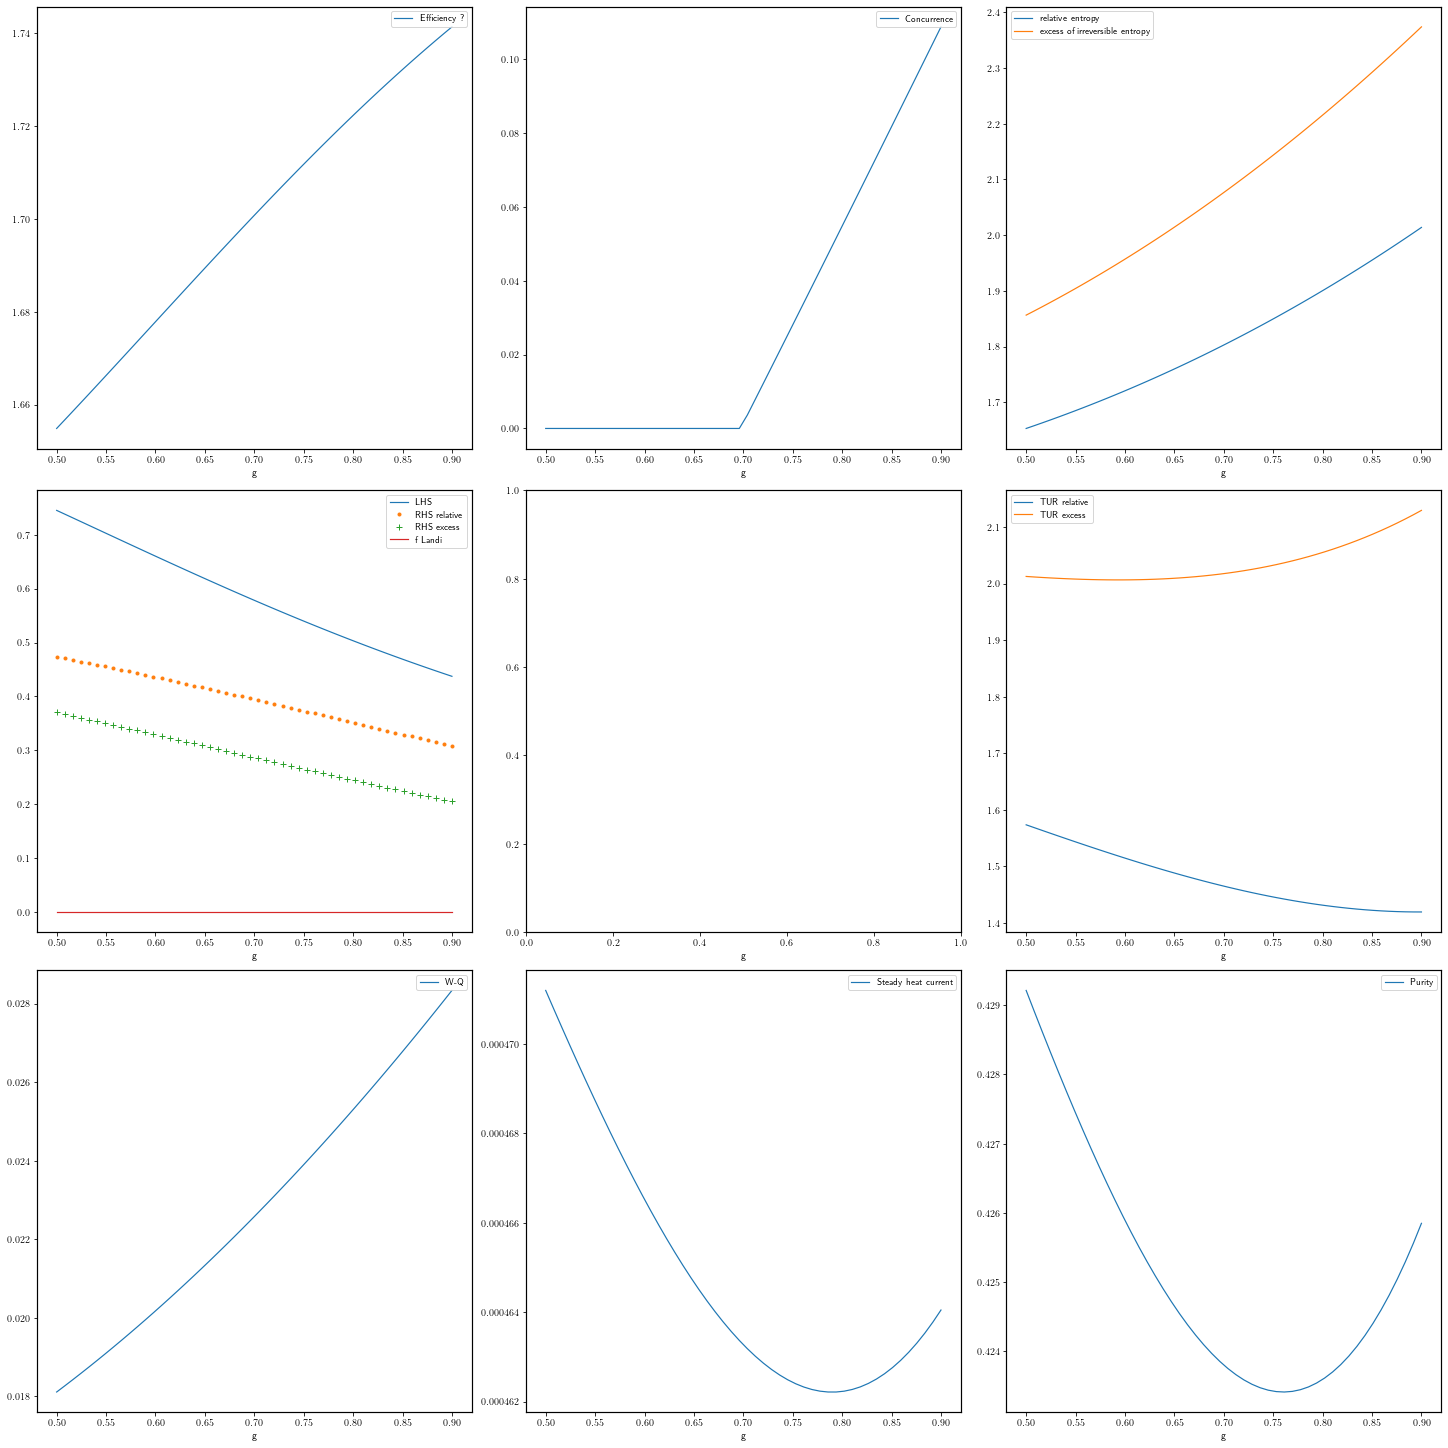

In [8]:
l=50
G=np.linspace(0.5,0.9,l) #different coupling strength
Peres,C,En,W,LHS,Srel,RHSrel=np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l)
Jh,Purity,MutInfo,Se,RHSe,heatDiff,coldDiff,efficiency=np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l)
LHSLandi,flandi,Sirr=np.zeros(l),np.zeros(l),np.zeros(l)

# for each value of the coupling strength G, compute everything
for i in range(l):
    rho = steadystate(rates(G[i]))
    Purity[i]=np.trace(rho**2)
    Peres[i]=PPT(rho) #entanglement criterion
    C[i]=concurrence(rho) #another
    En[i]=logneg(rho) #another
    H = np.array([[0,0,0,0],[0,omega,G[i],0],[0,G[i],omega,0],[0,0,0,2*omega]]) # Hamiltonian in 00 01 10 11 basis again
    W[i]=np.trace(H@U@rho@U.getH()-H@rho)#average work received by the system
    LHS[i]=work_squarred(rho,U,H)/(W[i]**2)-1 #left hand side of the TUR
    Srel[i]=np.trace(U@rho@U.getH()@(scipy.linalg.logm(U@rho@U.getH())-scipy.linalg.logm(rho))) #average entropy production
    RHSrel[i]=2/(m.exp(Srel[i])-1)
    heatDiff[i],coldDiff[i],Sirr[i]=excessHeat(G[i],rho,H)
    Se[i]=betaH*heatDiff[i]+betaC*coldDiff[i] #excess exchange
    RHSe[i]=2/(m.exp(Sirr[i])-1)
    Jh[i]=Jhot(rho,H,rates(G[i]))
    MutInfo[i]=mutualinfo(rho)
    efficiency[i]=-W[i]/heatDiff[i]
    l2=m.exp(-betaC*(omega))
    l3=m.exp(-betaH*(omega))
    l4=l2*l3
    normLandi=1+l2+l3+l4
    popLandi=[1/normLandi,l2/normLandi,l3/normLandi,l4/normLandi]
    LHSLandi[i]=(popLandi[1]+popLandi[2])/((popLandi[1]-popLandi[2])**2)-1
    #flandi[i]=landibound(W[i])
    

#plot
#img = plt.imread("concurrence purity.png")
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(20,20),constrained_layout='True')
#axs[0,0].plot(G,Peres,label='PPT')
#axs[0,0].plot(G,MutInfo,label='Mutual information')
axs[0,0].plot(G,efficiency,label='Efficiency ?')
axs[0,1].plot(G,C,label='Concurrence')
#axs[0,2].plot(G,En,label='log negativity')
axs[0,2].plot(G,Srel,label='relative entropy')
axs[0,2].plot(G,Sirr,label='excess of irreversible entropy')
axs[1,0].plot(G,LHS,label='LHS')
axs[1,0].plot(G,RHSrel,".",label='RHS relative')
axs[1,0].plot(G,RHSe,"+",label='RHS excess')
#axs[1,0].plot(G,LHSLandi,label="LHS Landi")
axs[1,0].plot(G,flandi,label="f Landi")
#axs[1,1].imshow(img, extent=[0, 1, 0, 1])
#axs[1,1].plot(Purity,C,label='Concurrence')
#axs[1,1].set_ylim([0,1])
#axs[1,1].set_xlim([0,1])
axs[1,2].plot(G,LHS/RHSrel,label="TUR relative")
axs[1,2].plot(G,LHS/RHSe,label="TUR excess")
axs[2,0].plot(G,-W-heatDiff-coldDiff,label='W-Q')#axs[2,1].set_ylim([0,0.002])
axs[2,1].plot(G,Jh,label='Steady heat current')
axs[2,2].plot(G,Purity,label='Purity')
plt.setp(axs[:,:], xlabel=('g'))
#plt.setp(axs[1,1], xlabel=('Purity'))
axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
#axs[1,1].legend()
axs[1,2].legend()
axs[2,0].legend()
axs[2,1].legend()
axs[2,2].legend()
#plt.savefig("Heat current Hofer article.png",dpi=300)

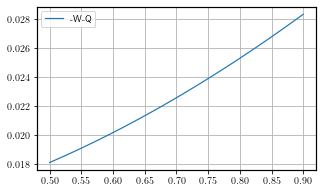

In [9]:
plt.figure(figsize=(5,3))
plt.plot(G,-W-heatDiff-coldDiff,label='-W-Q')
plt.legend()
plt.grid()

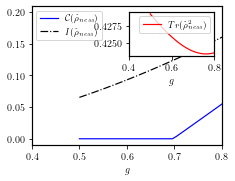

In [10]:
fig,ax1=plt.subplots()
ax1.set_xlabel(r'$g$')
ax1.plot(G,C,color="blue",label=r'$\mathcal{C}(\hat{\rho}_{ness})$')
ax1.plot(G,MutInfo,"-.",color="black",label=r"$I(\hat{\rho}_{ness})$")
ax1.set_xlim(0.4,0.8)
left, bottom, width, height = [0.52, 0.61, 0.35, 0.24]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlabel(r'$g$')
ax2.plot(G,Purity,color="red",label=r'$Tr({\hat{\rho}_{ness}}^2)$')
ax2.set_xlim(0.4,0.8)
ax1.legend()
ax2.legend()
########export
nameout = "ConcPurbetah1betac3nu0,004omega1"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

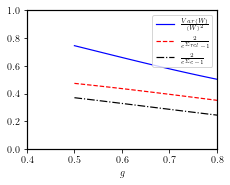

In [11]:
fig,ax1=plt.subplots()
ax1.set_xlabel(r'$g$')
ax1.plot(G,LHS,color="blue",label=r'$\frac{Var(W)}{\langle W\rangle^2}$')
ax1.plot(G,RHSrel,"--",color="red",label=r'$\frac{2}{e^{\Sigma_{rel}}-1}$')
#ax1.plot(G,LHSLandi,":",color="black",label=r"$\frac{Var(W)}{\langle W\rangle^2} (g=0)$")
ax1.plot(G,RHSe,"-.",color="black",label=r"$\frac{2}{e^{\Sigma_e}-1}$")
ax1.set_xlim(0.4,0.8)
ax1.set_ylim(0,1)
ax1.legend()
########export
nameout = "TURbetah1betac3nu0,004omega1"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

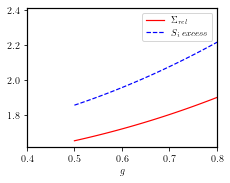

In [12]:
fig,ax1=plt.subplots()
ax1.set_xlabel(r'$g$')
ax1.plot(G,Srel,color="red",label=r'$\Sigma_{rel}$')
ax1.plot(G,Sirr,"--",color="blue",label=r'$S_i \; excess$')
ax1.set_xlim(0.4,0.8)
ax1.legend()
nameout="relativeandexcessentropybetah1betac3nu0,004omega1"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

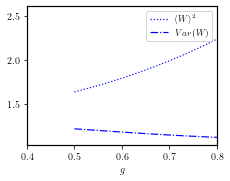

In [13]:
fig,ax1=plt.subplots()
ax1.set_xlabel(r'$g$')
ax1.plot(G,W**2,":",color="blue",label=r'$\langle W\rangle^2$')
ax1.plot(G,LHS*(W**2),"-.",color="blue",label=r'$Var(W)$')
ax1.set_xlim(0.4,0.8)
ax1.legend()
########export
nameout = "workasfunctionofgetah1betac3nu0,004omega1"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

In [14]:

G=0.5
time=1000
Nstep=200
rho=steadystate(rates(G))
y0=U@rho@U.getH()
y0=np.array(y0).reshape(16) #set initial state
H = np.array([[0,0,0,0],[0,omega,G,0],[0,G,omega,0],[0,0,0,2*omega]])


def lindblad1D(t,rho):
        r=np.array(rho.reshape(4,4),dtype=complex)
        return lindblad(r,H,rates(G)).reshape(16)

solu=scipy.integrate.solve_ivp(lindblad1D,(0,time),y0,t_eval=np.linspace(0,time,Nstep),rtol=10**-5,atol=10**-7)

distance,entropyFlux,entropyExcess,coldCurrent=np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex),np.zeros(len(solu.t),dtype=complex)
hotCurrent=np.zeros(len(solu.t),dtype=complex)
steadycurrent=Jhot(rho,H,rates(G))
steadyEntropy=steadycurrent*(betaC-betaH)
Sdot=np.zeros(len(solu.t),dtype=complex)
Si=np.zeros(len(solu.t),dtype=complex)

for i in range(len(solu.t)):
    x=np.array(solu.y[:,i].reshape(4,4),dtype=complex) # instant rho matrix
    distance[i]=np.trace((x-rho)@np.asmatrix(x-rho).getH())
    #entropyFlux[i]=entropyProd(x,H,rates(G),betaC,betaH)
    hotCurrent[i]=Jhot(x,H,rates(G))
    coldCurrent[i]=Jcold(x,H,rates(G))
    entropyFlux[i]=coldCurrent[i]*betaC+hotCurrent[i]*betaH
    entropyExcess[i]=-entropyFlux[i]+steadyEntropy
    Sdot[i]=-np.trace(lindblad(x,H,rates(G))@(scipy.linalg.logm(x)+np.identity(4)))
    Si[i]=Sdot[i]-entropyFlux[i]

C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [15]:
print(sum(Sdot))

(0.006810059112557415-4.4266296065525374e-32j)


C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  r

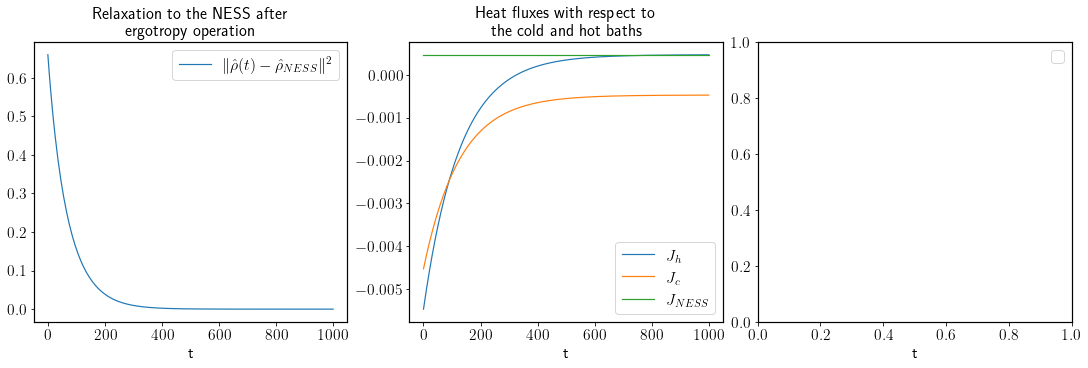

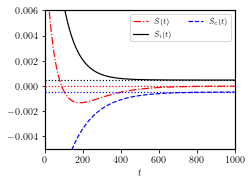

In [16]:
#plot

fig, axs2 = plt.subplots(1,3,figsize=(15,5),constrained_layout=True)
axs2[0].plot(solu.t,distance,label=r'$\Vert\hat{\rho}(t)-\hat{\rho}_{NESS}\Vert^2$')
axs2[0].set_title("Relaxation to the NESS after\n ergotropy operation",fontsize=17)
axs2[1].plot(solu.t,hotCurrent,label=r'$J_h$')
axs2[1].plot(solu.t,coldCurrent,label=r'$J_c$')
axs2[1].plot(solu.t,[steadycurrent]*len(solu.t),label=r'$J_{NESS}$')
axs2[1].set_title("Heat fluxes with respect to\n the cold and hot baths",fontsize=17)
#axs2[2].plot(solu.t,entropyExcess,label='Entropy excess ?')
#axs2[2].plot(solu.t,[steadyEntropy]*len(solu.t),label=r'$\Sigma_\infty=J_{NESS}(\beta_c-\beta_h)$')
#axs2[2].set_title("Difference between the\n entropy fluxes",fontsize=17)
for i in range(3):
    axs2[i].tick_params(axis='x', labelsize="xx-large")
    axs2[i].tick_params(axis='y', labelsize="xx-large")
    axs2[i].legend(fontsize=16)
    axs2[i].set_xlabel("t",fontsize=16)


fig,ax1=plt.subplots()
ax1.plot(solu.t,Sdot,"-.",color="red",label=r'$\dot{S}(t)$')
ax1.plot(solu.t,[0]*len(solu.t),":",color="red")
ax1.plot(solu.t,Si,color="black",label=r"$\dot{S}_i(t)$")
ax1.plot(solu.t,[steadyEntropy]*len(solu.t),":",color="black")
ax1.plot(solu.t,entropyFlux,"--",color="blue",label=r'$\dot{S}_e(t)$')
ax1.plot(solu.t,[-steadyEntropy]*len(solu.t),":",color="blue")
ax1.set_xlabel(r'$t$')
ax1.set_ylim(-0.005,0.006)
ax1.set_xlim(0,1000)
ax1.legend(loc="upper right",ncol=2,fontsize="small")
nameout = "transientbetah1betac3nu0,004omega1g0,5"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

In [17]:
distance

array([6.59739343e-01+0.j, 6.10522342e-01+0.j, 5.65462598e-01+0.j, 5.24140755e-01+0.j, 4.86187661e-01+0.j, 4.51277524e-01+0.j, 4.19122194e-01+0.j,
       3.89466363e-01+0.j, 3.62083328e-01+0.j, 3.36771149e-01+0.j, 3.13349425e-01+0.j, 2.91656734e-01+0.j, 2.71548344e-01+0.j, 2.52894191e-01+0.j,
       2.35577088e-01+0.j, 2.19491006e-01+0.j, 2.04539741e-01+0.j, 1.90636008e-01+0.j, 1.77700471e-01+0.j, 1.65660863e-01+0.j, 1.54451211e-01+0.j,
       1.44011090e-01+0.j, 1.34284873e-01+0.j, 1.25221438e-01+0.j, 1.16773803e-01+0.j, 1.08898722e-01+0.j, 1.01556329e-01+0.j, 9.47098099e-02+0.j,
       8.83250842e-02+0.j, 8.23704313e-02+0.j, 7.68164231e-02+0.j, 7.16357903e-02+0.j, 6.68032416e-02+0.j, 6.22952994e-02+0.j, 5.80901506e-02+0.j,
       5.41675099e-02+0.j, 5.05084404e-02+0.j, 4.70952155e-02+0.j, 4.39113321e-02+0.j, 4.09414259e-02+0.j, 3.81711877e-02+0.j, 3.55872863e-02+0.j,
       3.31772965e-02+0.j, 3.09296342e-02+0.j, 2.88334817e-02+0.j, 2.68786812e-02+0.j, 2.50557534e-02+0.j, 2.33558590e

C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\fcentrone\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


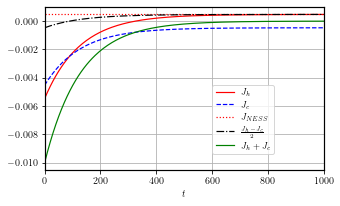

In [18]:
fig, axs2 =plt.subplots(figsize=(5,3))
axs2.plot(solu.t,hotCurrent,color="red",label=r'$J_h$')
axs2.plot(solu.t,coldCurrent,"--",color="blue",label=r'$J_c$')
axs2.plot(solu.t,[steadycurrent]*len(solu.t),":",color="red",label=r'$J_{NESS}$')
axs2.plot(solu.t,(hotCurrent-coldCurrent)/2,"-.",color="black",label=r"$\frac{J_h-J_c}{2}$")
axs2.plot(solu.t,(hotCurrent+coldCurrent),color="green",label=r"$J_h+J_c$")
axs2.set_xlim(0,1000)
axs2.set_xlabel(r'$t$')
axs2.legend(loc=(0.6,0.1))
plt.grid()
nameout="transientheatcurrentbetah1betac3nu0,004omega1g0,5"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

In [19]:
def redfield(r,Ho,rates): #arguments in qubit basis
    rho=P.getH()@r@P #energy basis
    H=P.getH()@Ho@P
    a,b,c,d,e,f,g,h = rates
    Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
    Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
    Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lind= -1j*(H@rho-rho@H)+a*LO(Lcminus.getH(),rho)+b*LO(Lcminus,rho)+c*LO(Lcplus.getH(),rho)+d*LO(Lcplus,rho)+e*LO(Lhminus.getH(),rho)+f*LO(Lhminus,rho)+g*LO(Lhplus.getH(),rho)+h*LO(Lhplus,rho)
    r1=0.5*(a+c+e+g)*(Lcplus.getH()@rho@Lcminus-0.5*(Lcminus@Lcplus.getH()@rho+rho@Lcminus@Lcplus.getH())+Lcminus.getH()@rho@Lcplus-0.5*(Lcplus@Lcminus.getH()@rho+rho@Lcplus@Lcminus.getH()))
    r2=0.5*(b+d+f+h)*(Lcplus@rho@Lcminus.getH()-0.5*(Lcminus.getH()@Lcplus@rho+rho@Lcminus.getH()@Lcplus)+Lcminus@rho@Lcplus.getH()-0.5*(Lcplus.getH()@Lcminus@rho+rho@Lcplus.getH()@Lcminus))
    rep=r1+r2+Lind
    return P@rep@P.getH() #result in the qubit basis

def JhotRed(r,Ho,rates):
    rho=P.getH()@r@P #energy basis
    H=P.getH()@Ho@P
    a,b,c,d,e,f,g,h = rates
    Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
    Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
    Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    h0=e*LO(Lhminus.getH(),rho)+f*LO(Lhminus,rho)+g*LO(Lhplus.getH(),rho)+h*LO(Lhplus,rho)
    h1=0.5*(e+g)*(Lcplus.getH()@rho@Lcminus-0.5*(Lcminus@Lcplus.getH()@rho+rho@Lcminus@Lcplus.getH())+Lcminus.getH()@rho@Lcplus-0.5*(Lcplus@Lcminus.getH()@rho+rho@Lcplus@Lcminus.getH()))
    h2=0.5*(f+h)*(Lcplus@rho@Lcminus.getH()-0.5*(Lcminus.getH()@Lcplus@rho+rho@Lcminus.getH()@Lcplus)+Lcminus@rho@Lcplus.getH()-0.5*(Lcplus.getH()@Lcminus@rho+rho@Lcplus.getH()@Lcminus))
    Redh=h0+h1+h2
    return np.trace(H@Redh)

def JcoldRed(r,Ho,rates):
    rho=P.getH()@r@P #energy basis
    H=P.getH()@Ho@P
    a,b,c,d,e,f,g,h = rates
    Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
    Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
    Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    c0=a*LO(Lcminus.getH(),rho)+b*LO(Lcminus,rho)+c*LO(Lcplus.getH(),rho)+d*LO(Lcplus,rho)
    c1=0.5*(a+c)*(Lcplus.getH()@rho@Lcminus-0.5*(Lcminus@Lcplus.getH()@rho+rho@Lcminus@Lcplus.getH())+Lcminus.getH()@rho@Lcplus-0.5*(Lcplus@Lcminus.getH()@rho+rho@Lcplus@Lcminus.getH()))
    c2=0.5*(b+d)*(Lcplus@rho@Lcminus.getH()-0.5*(Lcminus.getH()@Lcplus@rho+rho@Lcminus.getH()@Lcplus)+Lcminus@rho@Lcplus.getH()-0.5*(Lcplus.getH()@Lcminus@rho+rho@Lcplus.getH()@Lcminus))
    Redc=c0+c1+c2
    return np.trace(H@Redc)

In [20]:
redmatrix=np.zeros((16,16),dtype="complex")
G=0.5
omega=1
H = np.array([[0,0,0,0],[0,omega,G,0],[0,G,omega,0],[0,0,0,2*omega]])
for i in range(4):
    for j in range(4):
        M=np.zeros((4,4))
        M[i,j]=1
        V=np.asarray(redfield(M,H,rates(G))).reshape(16)
        for k in range(16):
            redmatrix[k,4*i+j]=V[k]
ker=scipy.linalg.null_space(redmatrix)
ker=ker.reshape(4,4)
steadyred=ker/np.real(np.trace(ker.reshape(4,4)))
print(np.trace(steadyred))

(1+2.1719491659289046e-16j)


C:\Users\FCENTR~1\AppData\Local\Temp/ipykernel_16520/133957159.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  J[i]=JhotRed(rho,H,rates(G[i]))


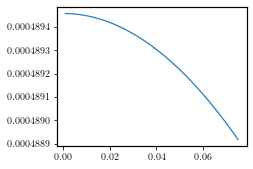

In [21]:
#Heat current for Redfield equation
#betaC=2
#betaH=0.2
#nuC=nuH=0.005 #Hofer parameters
l=50
G=np.linspace(0.001,0.075,l)
J=np.zeros(l)
time=5000
Nstep=5

def steadyRedfield(rates,H):
    """
    rho=steadystate(Rates).reshape(16)
    def redfield1D(t,rho):
        r=np.array(rho.reshape(4,4),dtype=complex)
        return redfield(r,H,Rates).reshape(16)
    solu=scipy.integrate.solve_ivp(redfield1D,(0,time),y0,t_eval=np.linspace(0,time,Nstep),rtol=10**-5,atol=10**-7)
    return np.array(solu.y[:,Nstep-1].reshape(4,4),dtype=complex)"""
    redmatrix=np.zeros((16,16),dtype="complex")
    for i in range(4):
        for j in range(4):
            M=np.zeros((4,4))
            M[i,j]=1
            V=np.asarray(redfield(M,H,rates)).reshape(16)
            for k in range(16):
                redmatrix[k,4*i+j]=V[k]
    ker=scipy.linalg.null_space(redmatrix)
    ker=ker.reshape(4,4)
    steadyred=ker/np.real(np.trace(ker.reshape(4,4)))
    return steadyred

for i in range(l):
    H = np.array([[0,0,0,0],[0,omega,G[i],0],[0,G[i],omega,0],[0,0,0,2*omega]])
    rho=steadyRedfield(rates(G[i]),H)
    J[i]=JhotRed(rho,H,rates(G[i]))

plt.plot(G,J)

TypeError: set_ticks() takes 2 positional arguments but 3 were given

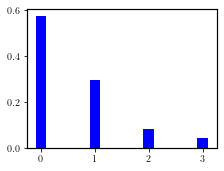

In [22]:
# visualise ergotropy and populations (purity, entanglement) by changing the variable "coupling" (G=coupling)
coupling=0.5 # best case for engine regime with betaH/betaC=1/2
#for the Landi engine, the efficiency is Otto ?
omega=1
rho=steadystate(rates(coupling))
r=P.getH()@rho@P
pop=np.diag(r)
x=np.arange(4)

labels=["0", r'$\Omega-g$', r"$\Omega+g$", r"$2\Omega$"]
width=0.2

fig, ax = plt.subplots()
rect1=ax.bar(x,pop,width,color="blue")
#rect2=ax.bar(x+width/2,popLandi,width,label="Separated state")
ax.set_xticks(x,labels)
ax.set_xlabel(r"$Energy\; levels$")
ax.set_ylabel(r"$Population$")

nameout = "populationbetah1betac3nu0,004omega1g0,5"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')
print(rates(coupling))
print(r)

In [ ]:
# colormap of concurrence

def steadystateColor(betaC,betaH,nuC,nuH,G,omega): # in 00 01 10 11 basis
    a=nuC*(omega-G)/(m.exp(betaC*(omega-G))-1) #GAMMA c omega-G
    e=nuH*(omega-G)/(m.exp(betaH*(omega-G))-1) #GAMMA h omega-G
    c=nuC*(omega+G)/(m.exp(betaC*(omega+G))-1) #GAMMA c omega+G
    g=nuH*(omega+G)/(m.exp(betaH*(omega+G))-1) #GAMMA h omega+G
    b=a*m.exp(betaC*(omega-G)) #GAMMA hat c omega-G
    d=c*m.exp(betaC*(omega+G)) #GAMMA hat c omega+G
    f=e*m.exp(betaH*(omega-G)) #GAMMA hat h omega-G
    h=g*m.exp(betaH*(omega+G)) #GAMMA hat h omega+G
    
    rho0=(b+f)*(d+h)
    rhoOplusG=(b+f)*(c+g)
    rhoOminusG=(a+e)*(d+h)
    rho2O=(a+e)*(c+g)
    r=np.diag([rho0,rhoOminusG,rhoOplusG,rho2O])
    r=r/np.trace(r)
    return P@r@P.getH()

omega=1
G=0.8
H = np.array([[0,0,0,0],[0,omega,G,0],[0,G,omega,0],[0,0,0,2*omega]])
n=60 #number of points
betaH=1
nuH=0.004
nuCmax=0.012
nuCold=np.linspace(0,nuCmax,num=n)
betaCold=np.linspace(1,7,num=n)
cmap=np.zeros((n,n))
for i in range(n):
    for j in range(n):
        cmap[i,j]=concurrence(steadystateColor(betaCold[i],betaH,nuCold[j],nuH,G,omega))

plt.figure()
#plt.title('Concurrence colormap')
plt.imshow(cmap, origin='lower', interpolation="none")
ticks=[0,20,40]
plt.xticks(ticks,["0","1","2"])  # nuCold, need to set the ticks manually
plt.xlabel(r"$\nu_c/\nu_h$")
plt.yticks(ticks,["1","3","5"])
plt.ylabel(r"$\beta_c/\beta_h$",rotation=0)
plt.colorbar()
nameout = "concurrence colormap betah=1 nuh=0.004 omega=1 g=0.8"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

In [ ]:
cmap=np.zeros((n,n))
for i in range(n):
    for j in range(n):
        rho=steadystateColor(betaCold[i],betaH,nuCold[j],nuH,G,omega)
        cmap[i,j]=np.trace(H@U@rho@U.getH()-H@rho)

plt.figure()
#plt.title('Concurrence colormap')
plt.imshow(cmap, origin='lower', interpolation="none")
ticks=[0,20,40]
plt.xticks(ticks,["0","1","2"])  # nuCold, need to set the ticks manually
plt.xlabel(r"$\nu_c/\nu_h$")
plt.yticks(ticks,["1","3","5"])
plt.ylabel(r"$\beta_c/\beta_h$",rotation=0)
plt.colorbar()
nameout = "workcolormapbetah1nuh0,004omega1g0,8"
#plt.savefig(nameout+'.pdf', dpi=300, bbox_inches='tight')

In [ ]:
def steadystateEig(rates): #hamiltonian basis
    a,b,c,d,e,f,g,h = rates
    rho0=(b+f)*(d+h)
    rhoOplusG=(b+f)*(c+g)
    rhoOminusG=(a+e)*(d+h)
    rho2O=(a+e)*(c+g)
    r=np.diag([rho0,rhoOminusG,rhoOplusG,rho2O])
    return r/np.trace(r)

def lindbladEig(rho,H,rates):
    a,b,c,d,e,f,g,h = rates
    Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
    Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
    Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
    rep= -1j*(H@rho-rho@H)+a*LO(Lcminus.getH(),rho)+b*LO(Lcminus,rho)+c*LO(Lcplus.getH(),rho)+d*LO(Lcplus,rho)+e*LO(Lhminus.getH(),rho)+f*LO(Lhminus,rho)+g*LO(Lhplus.getH(),rho)+h*LO(Lhplus,rho)
    return rep
G=0.5
H=np.diag([0,omega-G,omega+G,2*omega])
r=steadystateEig(rates(G))
print(H)
print(r)
print(lindbladEig(r,H,rates(G)))

In [ ]:
G=0.5
omega=1
H = np.array([[0,0,0,0],[0,omega,G,0],[0,G,omega,0],[0,0,0,2*omega]])
rho=steadystate(rates(G))
print(P.getH()@rho@P)
U=np.matrix([[1,0,0,1],[0,1,0,0],[0,0,-1,0],[0,0,0,1]])
W=np.trace(H@U@rho@U.getH()-H@rho)#average work received by the system
LHS=work_squarred(rho,U,H)/(W**2)-1
print(W,LHS)
U=np.matrix([[0,0,0,1],[0,1,0,0],[0,0,-1,0],[1,0,0,0]])
W=np.trace(H@U@rho@U.getH()-H@rho)#average work received by the system
LHS=work_squarred(rho,U,H)/(W**2)-1
print(W,LHS)
U=np.matrix([[0,0,0,1],[0,1,0,0],[0,0,1,0],[1,0,0,0]])
W=np.trace(H@U@rho@U.getH()-H@rho)#average work received by the system
LHS=work_squarred(rho,U,H)/(W**2)-1
print(W,LHS)

In [ ]:
def landibound(x):
    def xta(y):
        return y*np.tanh(y)-x/2
    return 1/np.sinh(scipy.optimize.root_scalar(xta,x0=0,x1=100).root)**2
tab=np.linspace(0,10,50)
sol=np.zeros(50)
y=np.zeros(50)
def f(x):
    return x*np.tanh(x)-5
scipy.optimize.root_scalar(f,x0=0,x1=50).root

In [ ]:
l=50
G=np.linspace(0.1,0.9,l) #different coupling strength
Peres,C,En,W,LHS,Srel,RHSrel=np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l)
Jh,Purity,MutInfo,Se,RHSe,heatDiff,coldDiff,efficiency=np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l)
LHSLandi,flandi,Sirr=np.zeros(l),np.zeros(l),np.zeros(l)

# for each value of the coupling strength G, compute everything
for i in range(l):
    rho = steadystate(rates(G[i]))
    Purity[i]=np.trace(rho**2)
    Peres[i]=PPT(rho) #entanglement criterion
    C[i]=concurrence(rho) #another
    En[i]=logneg(rho) #another
    H = np.array([[0,0,0,0],[0,omega,G[i],0],[0,G[i],omega,0],[0,0,0,2*omega]]) # Hamiltonian in 00 01 10 11 basis again
    W[i]=np.trace(H@U@rho@U.getH()-H@rho)#average work received by the system
    LHS[i]=work_squarred(rho,U,H)/(W[i]**2)-1 #left hand side of the TUR
    Srel[i]=np.trace(U@rho@U.getH()@(scipy.linalg.logm(U@rho@U.getH())-scipy.linalg.logm(rho))) #average entropy production
    RHSrel[i]=2/(m.exp(Srel[i])-1)
    heatDiff[i],coldDiff[i],Sirr[i]=excessHeat(G[i],rho,H)
    Se[i]=betaH*heatDiff[i]+betaC*coldDiff[i] #excess exchange
    RHSe[i]=2/(m.exp(Sirr[i])-1)
    Jh[i]=Jhot(rho,H,rates(G[i]))
    MutInfo[i]=mutualinfo(rho)
    efficiency[i]=-W[i]/heatDiff[i]
    l2=m.exp(-betaC*(omega))
    l3=m.exp(-betaH*(omega))
    l4=l2*l3
    normLandi=1+l2+l3+l4
    popLandi=[1/normLandi,l2/normLandi,l3/normLandi,l4/normLandi]
    LHSLandi[i]=(popLandi[1]+popLandi[2])/((popLandi[1]-popLandi[2])**2)-1
    #flandi[i]=landibound(W[i])
    

#plot
#img = plt.imread("concurrence purity.png")
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(20,20),constrained_layout='True')
#axs[0,0].plot(G,Peres,label='PPT')
#axs[0,0].plot(G,MutInfo,label='Mutual information')
axs[0,0].plot(G,efficiency,label='Efficiency ?')
axs[0,1].plot(G,C,label='Concurrence')
#axs[0,2].plot(G,En,label='log negativity')
axs[0,2].plot(G,Srel,label='relative entropy')
axs[0,2].plot(G,Sirr,label='excess of irreversible entropy')
axs[1,0].plot(G,LHS,label='LHS')
axs[1,0].plot(G,RHSrel,".",label='RHS relative')
axs[1,0].plot(G,RHSe,"+",label='RHS excess')
#axs[1,0].plot(G,LHSLandi,label="LHS Landi")
axs[1,0].plot(G,flandi,label="f Landi")
#axs[1,1].imshow(img, extent=[0, 1, 0, 1])
#axs[1,1].plot(Purity,C,label='Concurrence')
#axs[1,1].set_ylim([0,1])
#axs[1,1].set_xlim([0,1])
axs[1,2].plot(G,LHS/RHSrel,label="TUR relative")
axs[1,2].plot(G,LHS/RHSe,label="TUR excess")
axs[2,0].plot(G,-W-heatDiff-coldDiff,label='W-Q')#axs[2,1].set_ylim([0,0.002])
axs[2,1].plot(G,Jh,label='Steady heat current')
axs[2,2].plot(G,Purity,label='Purity')
plt.setp(axs[:,:], xlabel=('g'))
#plt.setp(axs[1,1], xlabel=('Purity'))
axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
#axs[1,1].legend()
axs[1,2].legend()
axs[2,0].legend()
axs[2,1].legend()
axs[2,2].legend()
#plt.savefig("Heat current Hofer article.png",dpi=300)

In [28]:
steadystateEig(rates(0.5))

array([[0.57640828, 0.        , 0.        , 0.        ],
       [0.        , 0.29683395, 0.        , 0.        ],
       [0.        , 0.        , 0.08367006, 0.        ],
       [0.        , 0.        , 0.        , 0.04308771]])

In [ ]:
(array([0.04308771, 0.08367006, 0.29683395, 0.57640828]),

In [ ]:
omega-0.5

In [ ]:
nuC,nuH,betaC

In [ ]:
np.linalg.eig(steadystate(rates(0.5)))

In [ ]:
rho

In [25]:
rates(0.5)

(0.001163953413738653,
 0.0031639534137386533,
 0.00031437417894753574,
 0.006314374178947537,
 0.0030829881650735963,
 0.005082988165073596,
 0.0017233015007332097,
 0.00772330150073321)

In [5]:
Lcminus=np.matrix([[0,-1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]]) #expressed in energy basis
Lcplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])
Lhminus=np.matrix([[0,1/m.sqrt(2),0,0],[0,0,0,0],[0,0,0,1/m.sqrt(2)],[0,0,0,0]])
Lhplus=np.matrix([[0,0,1/m.sqrt(2),0],[0,0,0,-1/m.sqrt(2)],[0,0,0,0],[0,0,0,0]])

In [11]:
Lhplus

matrix([[ 0.        ,  0.        ,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.70710678],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]])